<a href="https://colab.research.google.com/github/souravs17031999/Projects-kaggle-problems-60daysofudacity/blob/master/fruit_adulterated_classify.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Project : Food Adulteration Project 

## Kaggle dataset

In [6]:
!pip install kaggle
!mkdir .kaggle
import json
token = {"username":"souravs17031999","key":"995be9fc29359b1f43f1c40f14f28c48"} # copy the API from kaggle.json downloaded from kaggle account
with open('/content/.kaggle/kaggle.json', 'w') as file:
    json.dump(token, file)
!cp /content/.kaggle/kaggle.json ~/.kaggle/kaggle.json
!kaggle config set -n path -v{/content}
!chmod 600 /root/.kaggle/kaggle.json


mkdir: cannot create directory ‘.kaggle’: File exists
- path is now set to: {/content}


In [0]:
!kaggle datasets download -d sriramr/fruits-fresh-and-rotten-for-classification

In [0]:
!unzip ./{/content}/datasets/sriramr/fruits-fresh-and-rotten-for-classification/fruits-fresh-and-rotten-for-classification.zip

## Importing all required packages

In [0]:
# Imports here
from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
from torch.utils import data
import torch
from torch import nn
from torch import optim
import torchvision
import torch.nn.functional as F
from torchvision import datasets, transforms, models
import torchvision.models as models
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset, DataLoader
from skimage import io, transform
import torch.utils.data as data_utils
from PIL import Image, ImageFile
import json
from torch.optim import lr_scheduler
import time
import os
import argparse
import copy
import pandas as pd
ImageFile.LOAD_TRUNCATED_IMAGES = True

## Setting the dataset

In [0]:
# SETTING THE DIRECTORIES
dir = "dataset"
train_dir = dir + '/train'
test_dir = dir + '/test'

# APPLYING THE APPROPRIATE TRANSFORMS
train_transforms = transforms.Compose([transforms.RandomRotation(30),transforms.RandomResizedCrop(224),transforms.RandomHorizontalFlip(),transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])
test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])

# IMPORTING / DOWNLOADING THE DATASET
train_data = datasets.ImageFolder(train_dir , transform=train_transforms)
test_data = datasets.ImageFolder(test_dir, transform=test_transforms)

## Dividing training set into train and validation set and loading the data

In [11]:
# DIVIDING TRAINING SET INTO TRAIN SET AND VALIDATION SET
valid_size = 0.2
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# SAMPLING 
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# LOADING WITH DATA AUGMENTED
trainloader = torch.utils.data.DataLoader(train_data, batch_size=64,sampler=train_sampler)
validloader = torch.utils.data.DataLoader(train_data, batch_size=64, sampler=valid_sampler)
testloader = torch.utils.data.DataLoader(test_data, batch_size=64)

print(f"training examples contain : {len(train_data)}")
print(f"testing examples contain : {len(test_data)}")

print(len(trainloader))
print(len(validloader))
print(len(testloader))

training examples contain : 10901
testing examples contain : 2698
137
35
43


## Visualizing batches of data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Image shape : torch.Size([64, 3, 224, 224])
Label shape : torch.Size([64])
labels: tensor([0, 4, 0, 5, 3, 0, 3, 1, 4, 4, 5, 4, 0, 2, 5, 4, 3, 5, 1, 4, 0, 2, 2, 5,
        5, 1, 0, 2, 1, 5, 4, 3, 3, 4, 1, 4, 4, 3, 4, 4, 2, 3, 3, 2, 2, 0, 2, 1,
        1, 0, 0, 0, 4, 0, 3, 5, 0, 3, 4, 3, 4, 3, 1, 3])


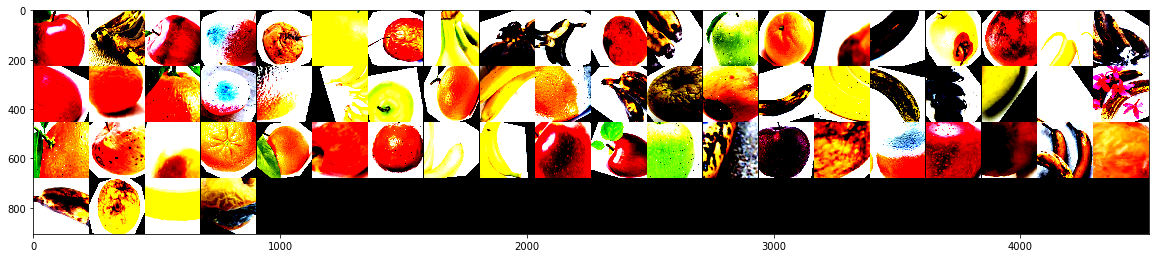

In [12]:
# LOAD ONE BATCH OF TESTING SET TO CHECK THE IMAGES AND THEIR LABELS
images, labels = next(iter(trainloader))

# Checking shape of image
print(f"Image shape : {images.shape}")
print(f"Label shape : {labels.shape}")

class_names = train_data.classes

# denormalizing images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# plotting the images of loaded batch with given fig size and frame data    
import torchvision
import matplotlib.pyplot as plt
import numpy as np
grid = torchvision.utils.make_grid(images, nrow = 20, padding = 2)
plt.figure(figsize = (20, 20))  
plt.imshow(np.transpose(grid, (1, 2, 0)))   
print('labels:', labels)

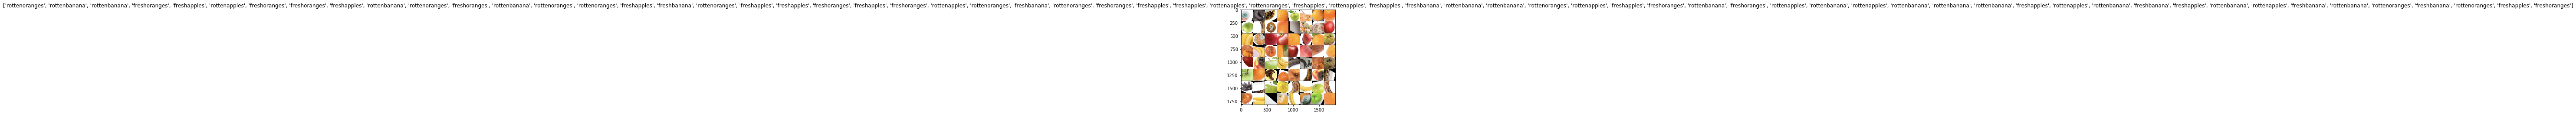

In [14]:
# Printing normalized images
images, labels = next(iter(trainloader))
out = torchvision.utils.make_grid(images)
imshow(out, title=[class_names[x] for x in labels])

## Check if cuda is enabled

In [15]:
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


## Getting the pretrained model resnet, setting up the final linear layers , defining optimizer and cost function

In [17]:
# defining device 
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# downloading model
model = models.resnet152(pretrained=True)  # if used inception , then use image size 299*299 otherwise 224*224 and use : model_ft.aux_logits=False to switch off auxiliary lyers
# setting firstly classifier only for training 
for param in model.parameters():
  param.requires_grad = False
  
# set inputs and output classes
num_ftrs = model.fc.in_features
out_ftrs = 6
  
model.fc = nn.Sequential(nn.Linear(num_ftrs, 512),nn.ReLU(),nn.Linear(512,out_ftrs),nn.LogSoftmax(dim=1))
# defining the loss function 
criterion = nn.NLLLoss()
  
# defining the optimizer and scheduler
optimizer = torch.optim.Adam(filter(lambda p:p.requires_grad,model.fc.parameters()) , lr = 0.001)
scheduler = lr_scheduler.StepLR(optimizer, step_size=6, gamma=0.1)

# sending the model to device - GPU OR CPU
print(model)
model.to(device);

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=F

## Training and validation loop

In [0]:
def train_and_test(e):
    epochs = e
    train_losses , test_losses = [] , []
    valid_loss_min = np.Inf 
    model.train()
    for epoch in range(epochs):
      running_loss = 0
      batch = 0
      scheduler.step()
      for images , labels in trainloader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        batch += 1
        if batch % 50 == 0:
          print(f" epoch {epoch + 1} batch {batch} completed")
      test_loss = 0
      accuracy = 0
      with torch.no_grad():
        model.eval() 
        for images , labels in validloader:
          images, labels = images.to(device), labels.to(device)
          logps = model(images) 
          test_loss += criterion(logps,labels) 
          ps = torch.exp(logps)
          top_p , top_class = ps.topk(1,dim=1)
          equals = top_class == labels.view(*top_class.shape)
          accuracy += torch.mean(equals.type(torch.FloatTensor))
      train_losses.append(running_loss/len(trainloader))
      test_losses.append(test_loss/len(validloader))
      print("Epoch: {}/{}.. ".format(epoch+1, epochs),"Training Loss: {:.3f}.. ".format(running_loss/len(trainloader)),"Valid Loss: {:.3f}.. ".format(test_loss/len(validloader)),
        "Valid Accuracy: {:.3f}".format(accuracy/len(validloader)))
      model.train() 
      if test_loss/len(validloader) <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,test_loss/len(validloader))) 
        valid_loss_min = test_loss/len(validloader)    
    return train_losses, test_losses
    

In [21]:
train_losses, test_losses = train_and_test(5)

 epoch 1 batch 50 completed
 epoch 1 batch 100 completed
Epoch: 1/5..  Training Loss: 0.321..  Valid Loss: 0.168..  Valid Accuracy: 0.950
Validation loss decreased (inf --> 0.167842).  Saving model ...
 epoch 2 batch 50 completed
 epoch 2 batch 100 completed
Epoch: 2/5..  Training Loss: 0.191..  Valid Loss: 0.112..  Valid Accuracy: 0.962
Validation loss decreased (0.167842 --> 0.112416).  Saving model ...
 epoch 3 batch 50 completed
 epoch 3 batch 100 completed
Epoch: 3/5..  Training Loss: 0.155..  Valid Loss: 0.171..  Valid Accuracy: 0.940
 epoch 4 batch 50 completed
 epoch 4 batch 100 completed
Epoch: 4/5..  Training Loss: 0.152..  Valid Loss: 0.131..  Valid Accuracy: 0.954
 epoch 5 batch 50 completed
 epoch 5 batch 100 completed
Epoch: 5/5..  Training Loss: 0.116..  Valid Loss: 0.102..  Valid Accuracy: 0.963
Validation loss decreased (0.112416 --> 0.101785).  Saving model ...


## Testing loop

In [23]:
accuracy = 0
with torch.no_grad():
    model.eval()
    p_labels = []
    img_ids = []
    i = 0
    for inputs, labels in testloader:
        i += 1
        inputs = inputs.to(device)
        labels = labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        temp_acc = torch.sum(preds == labels.data)
        accuracy += temp_acc
        p_labels.append(preds)
    print('Accuracy =====>>', accuracy.item()/len(test_data))

Accuracy =====>> 0.9870274277242401


## Getting the classes from train set

In [25]:
classes = train_data.classes
classes

['freshapples',
 'freshbanana',
 'freshoranges',
 'rottenapples',
 'rottenbanana',
 'rottenoranges']

## Testing for single image

In [0]:
def test_with_single_image(model, file, transform, classes):

    file = Image.open(file).convert('RGB')

    img = transform(file).unsqueeze(0)

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    with torch.no_grad():
        out = model(img.to(device))
        ps = torch.exp(out)
        top_p, top_class = ps.topk(1, dim=1)
        value = top_class.item()
        print("Value:", value)
        print(classes[value])
        plt.imshow(np.array(file))
        plt.show()

In [33]:
import random

# take random folder first
folders = os.listdir(test_dir)
num = random.randint(0, 1)
path = test_dir+"/"+folders[num]

# save label
label = folders[num]

# now take random file
files = os.listdir(path)
num = random.randint(0, len(files)-1)
name = path + "/" + files[num]

print("Real Label: ", label)
print('Path: ', name)

Real Label:  rottenoranges
Path:  dataset/test/rottenoranges/Screen Shot 2018-06-12 at 11.41.35 PM.png


Value: 5
rottenoranges


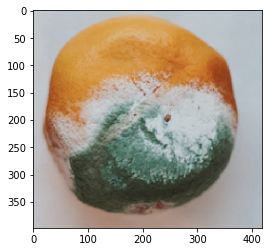

In [34]:
test_with_single_image(model, name, test_transforms, classes)

## Complexity graph 

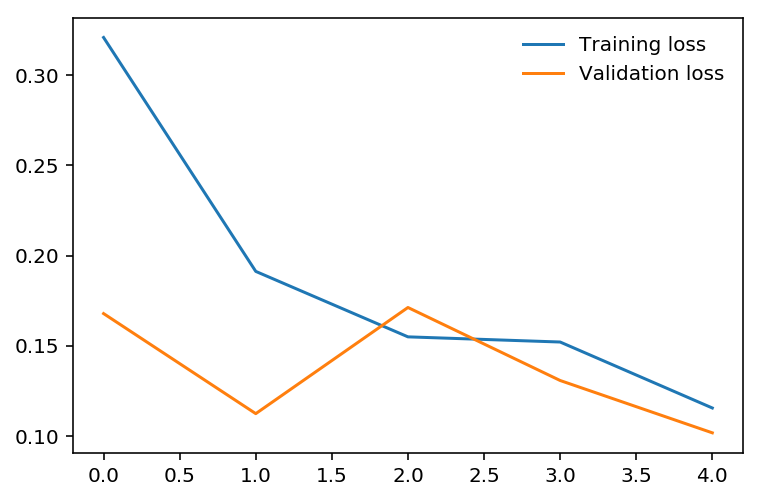

In [35]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)